(sec-get-started-dask-dataframe)=
# Dask DataFrame 快速入门

我们先使用 Dask DataFrame 演示一下如何使用 Dask 并行化 pandas DataFrame。

## 创建 Dask DataFrame

使用 Dask 内置的方法创建一个名为 `ddf` 的 `DataFrame`，这份数据是一个时间序列数据，是随机生成的，每个数据样本代表一秒钟，共计 4 天（从 2024-01-01 0:00 至 2024-01-05 0:00）。

In [1]:
import dask

ddf = dask.datasets.timeseries(start="2024-01-01",
    end="2024-01-05")
ddf

,name,id,x,y
npartitions=4,,,,
2024-01-01,string,int64,float64,float64
2024-01-02,...,...,...,...
2024-01-03,...,...,...,...
2024-01-04,...,...,...,...
2024-01-05,...,...,...,...


pandas 所有操作是立即（Eager）执行的。Dask 是延迟（Lazy）执行的，数据并没有开始计算，所以都用省略号 ... 表示。

虽然 `ddf` 的数据还没有被计算，但 Dask 已经获取了数据的列名和数据类型，用 `dtypes` 查看列：

In [2]:
ddf.dtypes

name    string[pyarrow]
id                int64
x               float64
y               float64
dtype: object

## 执行计算

如果想计算并得到结果，必须使用 `compute()` 手动触发计算。

In [3]:
ddf.compute()

,name,id,x,y
timestamp,,,,
2024-01-01 00:00:00,Zelda,988,-0.873067,0.157726
2024-01-01 00:00:01,Oliver,978,0.261735,0.516558
2024-01-01 00:00:02,Victor,985,0.510027,-0.259912
2024-01-01 00:00:03,Yvonne,999,-0.488090,0.463293
2024-01-01 00:00:04,Hannah,978,-0.879385,0.886313
...,...,...,...,...
2024-01-04 23:59:55,Xavier,995,0.650247,-0.699778
2024-01-04 23:59:56,Michael,1027,-0.850668,0.867499
2024-01-04 23:59:57,Ursula,969,0.032713,0.125985


Dask DataFrame 有一个重要的内置变量 `npartitions`，它表示将数据切分成了多少份，或者说一共有多少个分区（Partition）。如 {numref}`fig-dask-dataframe-partition` 所示，Dask DataFrame 是由多个 pandas DataFrame 组成的，每个 pandas DataFrame 又被称作一个 Partition。

In [4]:
ddf.npartitions

4

```{figure} ../img/ch-dask/dask-dataframe.svg
---
width: 400px
name: fig-dask-dataframe-partition
---
Dask DataFrame 是由多个 pandas DataFrame 组成
```

每个 Partition 有上界和下界。这个例子中 `ddf` 是根据时间列进行的切分，每天的数据组成一个 Partition。内置变量 `divisions` 存放着每个 Partition 的分界线：

In [5]:
ddf.divisions

(Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-02 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-04 00:00:00'),
 Timestamp('2024-01-05 00:00:00'))

## 索引

:::{note}

pandas `DataFrame` 有一列专门存放索引（Index），Index 可以是数字，比如行号；也可以是时间。Index 列通常只用于索引，不作为数据字段，在 `ddf.dtypes` 中看不到 Index 列。

:::

本例中，`ddf` 的 Index 是时间。每个 Partition 基于 Index 列进行切分。整个 `ddf` 是四天的数据，每个 Partition 是一天的数据。

现在我们选择 2024-01-01 0:00 至 2024-01-02 5:00 的数据，横跨了两天，横跨了两个 Partition。

In [6]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"]

,name,id,x,y
npartitions=2,,,,
2024-01-01 00:00:00.000000000,string,int64,float64,float64
2024-01-02 00:00:00.000000000,...,...,...,...
2024-01-02 05:00:59.999999999,...,...,...,...


还是需要使用 `compute()` 来触发计算，得到结果：

In [7]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"].compute()

,name,id,x,y
timestamp,,,,
2024-01-01 00:00:00,Zelda,988,-0.873067,0.157726
2024-01-01 00:00:01,Oliver,978,0.261735,0.516558
2024-01-01 00:00:02,Victor,985,0.510027,-0.259912
2024-01-01 00:00:03,Yvonne,999,-0.488090,0.463293
2024-01-01 00:00:04,Hannah,978,-0.879385,0.886313
...,...,...,...,...
2024-01-02 05:00:55,Bob,1029,0.218520,0.462808
2024-01-02 05:00:56,Alice,1005,0.722850,0.067173
2024-01-02 05:00:57,Tim,990,-0.343179,-0.812177



## pandas 兼容

Dask DataFrame 的大部分操作与 pandas 几乎一致，我们可以像使用 pandas 那样使用 Dask DataFrame。

比如数据过滤和 `groupby`：

In [8]:
ddf2 = ddf[ddf.y > 0]
ddf3 = ddf2.groupby("name").x.std()
ddf3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 10 graph layers

现在的结果仍然用省略号 ... 表示，因为计算被延迟执行，需要调用 `compute()` 触发执行。

In [9]:
computed_ddf = ddf3.compute()
computed_ddf

name
Alice       0.570873
Bob         0.574338
Charlie     0.577622
Dan         0.578480
Edith       0.579528
Frank       0.576647
George      0.576759
Hannah      0.580472
Ingrid      0.579585
Jerry       0.577015
Kevin       0.574981
Laura       0.578379
Michael     0.574430
Norbert     0.575075
Oliver      0.577198
Patricia    0.579569
Quinn       0.573159
Ray         0.577756
Sarah       0.573136
Tim         0.574545
Ursula      0.580282
Victor      0.578231
Wendy       0.576533
Xavier      0.578146
Yvonne      0.576635
Zelda       0.570968
Name: x, dtype: float64

## 计算图

至此，我们知道 Dask DataFrame 将大数据切分成了 Partition，并且延迟执行的。Dask 构建了 Task Graph，来分别对每个 Partition 进行了计算。

执行 `compute()` 之前，Dask 构建的是一个计算图 Task Graph，用 `visualize()` 可视化 Task Graph。

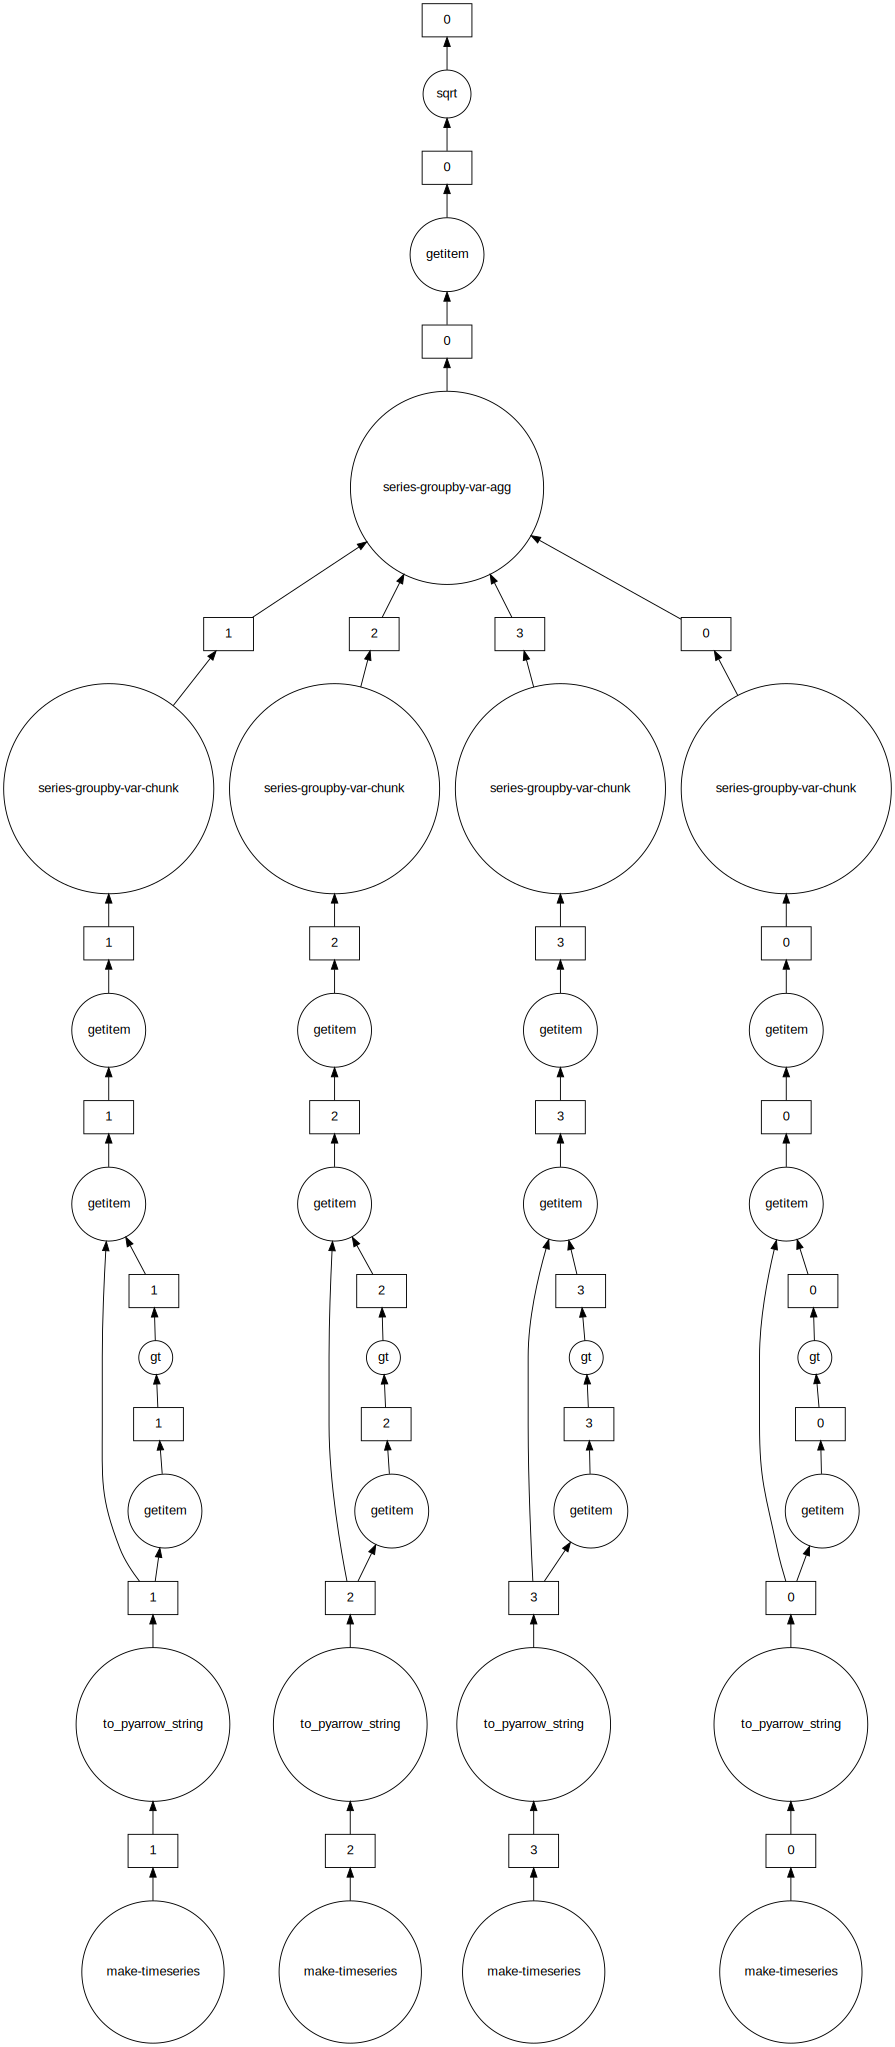

In [10]:
ddf3.visualize(filename="../img/ch-dask/visualize-task-graph", format="svg")

计算图中，圆圈表示计算，长方形表示数据。对于 Dask DataFrame 来说，长方形就是 pandas `DataFrame`。